## learning-AI101 : California housing price regression (ML)
### 캘리포니아 주택 시세 데이터를 KNN, multiple regression, SVM, lasso, ridge, decision tree, random forest, XGBoost, gradient boosting, GPR 기법을 적용하여 regression

<br>

- **임규연 (lky473736)**
- 2024.08.10.에 문서 작성
- **kaggle** : https://www.kaggle.com/datasets/camnugent/california-housing-prices
- **data abstract** : This is the dataset used in the second chapter of Aurélien Géron's recent book 'Hands-On Machine learning with Scikit-Learn and TensorFlow'. It serves as an excellent introduction to implementing machine learning algorithms because it requires rudimentary data cleaning, has an easily understandable list of variables and sits at an optimal size between being to toyish and too cumbersome. The data contains information from the 1990 California census. So although it may not help you with predicting current housing prices like the Zillow Zestimate dataset, it does provide an accessible introductory dataset for teaching people about the basics of machine learning.

------

### <mark>Attention!</mark>

본 문서부터 DL에 plaidml-keras를 이용한 GPU 가속화를 진행한다. 
- 참고 : https://www.facebook.com/groups/KerasKorea/permalink/3077728298909781/

현재 local computer의 사양은 아래와 같다.

- CPU : 2.6 GHz 6코어 Intel Core i7
- 외장 GPU : Radeon Pro 560X 4 GB
- RAM : 32GB 2400 MHz DDR4

위와 같은 사양으로 여태껏 가속화를 안하고 하염없이 fitting이 완료되기만 기다린 예전의 나에게 박수를 보낸다. 하지만, **ML에서는 앞으로도 줄곧, 하염없이 기다려야 한다.** 그 이유는 scikit-learn의 내부 구조가 CPU에 최적화되어 있으며, 이는 추후에도 지원하지 않을 계획이라고 공식 문서에서 언급되어 있다. (https://scikit-learn.org/stable/faq.html#will-you-add-gpu-support)

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

----
## <span id='ml'><mark>ML</mark></span>

machine learning으로 California housing price를 regression한다. 목차는 아래와 같다.

- **1. 데이터 EDA (탐색적 데이터 분석) 및 데이터 전처리**
- **2. 각종 모델을 적용하여 regression 및 각 모델의 score 비교**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

-------

### 1. 데이터 EDA (탐색적 데이터 분석)

regression 진행하기 전, 데이터 구조를 파악하고, 전처리를 진행한다.

- **데이터 구조 파악 및 EDA**
    - 각 feature가 의미하는 바를 분석, 결측치 파악 후 어떻게 classification을 진행하는 것이 탁월할 지 파악
    - 각 feature에 대한 사분위수, mean, max, min, median, corr
    - seaborn을 통한 corr 상관관계 및 histplot 시각화
    - 각 feature에 대한 box plot 시각화
    - target의 도수를 bar plot 시각화
    
- **전처리**
    - train, test, val set으로 split
    - scaling (Z-score normalization)
    - 결측치 확인 및 filling by everage value
    - Polynormial Feature
    
아래와 같은 순서로 진행한다.

- **순서**
    - (1) dataframe으로 파일 열기 및 head, info 파악
    - (2) 각 describe를 통한 편향성 확인 및 기초통계량 확인
    - (3) seaborn heatmap로 상관관계 파악
    - (4) seaborn pairplot으로 상관관계 시각화
    - (5) outlier 확인 위해 boxplot 시각화
    - (6) 결측치 확인 및 filling by evarage value
    - (7) input, target set -> train, test, val set으로 split
    - (8) Polynormial Feature set 생성
    - (9) scaling (Z-score normalization)

#### (1) dataframe으로 파일 열기 및 head, info 파악

In [3]:
# 파일 열기 및 head, info 파악

df = pd.read_csv ('data/california_house_prices.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  20640 non-null  int64  
 1   MedInc      20640 non-null  float64
 2   HouseAge    20640 non-null  float64
 3   AveRooms    20640 non-null  float64
 4   AveBedrms   20640 non-null  float64
 5   Population  20640 non-null  float64
 6   AveOccup    20640 non-null  float64
 7   Latitude    20640 non-null  float64
 8   Longitude   20640 non-null  float64
 9   PRICE       20640 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.6 MB


,Unnamed: 0,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
0,0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


위를 확인해보니, 첫번째 열이 각 행의 번호를 매기는 index임을 알 수 있다. 본 열을 삭제한다.

In [4]:
# 열 삭제 (Unnamed: 0)

df = df.drop("Unnamed: 0", axis=1)
df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'PRICE'],
      dtype='object')

#### (2) 각 describe를 통한 편향성 확인 및 기초통계량 확인

In [5]:
# 기초통계량 확인

df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


위를 확인해보니, 아래와 같은 사실을 확인 가능하다.

- **MedInc의 평균값** 
    - MedInc의 평균은 약 3.87로, 이는 해당 지역 주민의 평균 소득이 상대적으로 낮지 않다는 걸 알 수 있다. 
    - 특히 25%와 75%의 사분위수를 보면 소득의 분포가 매우 넓게 퍼져 있음을 알 수 있다. 

- **HouseAge의 분포** 
    - HouseAge의 최대값이 52로 되어 있는 것으로 보아, 데이터에는 52년 이상 된 집들은 포함되지 않았거나, 52년 이상된 모든 집이 하나의 그룹으로 묶였을 가능성이 있다고 생각한다.
    - 평균 주택 연령은 약 28.6년으로, 비교적 오래된 주택들이 많을 수 있다.

- **AveRooms와 AveBedrms의 비율** 
    - AveRooms와 AveBedrms의 평균값이 각각 5.43과 1.10으로, 평균적으로 하나의 집당 약 5개의 방과 1개의 침실이 있다는 것을 의미한다.
    - 5개의 방과 1개의 침실이라니... 대부분의 집은 매우 넓다.

- **Population의 큰 범위** 
    - Population (인구 수)의 최소값과 최대값이 각각 3명에서 35682명으로, 특정 지역의 인구 분포가 매우 다양하며, 일부 지역은 매우 인구 밀도가 높고, 다른 지역은 극히 낮음을 알 수 있다.

- **Latitude와 Longitude의 범위**
    - Latitude (위도)와 Longitude (경도)의 범위를 보자. 데이터는 주로 캘리포니아 주의 지리적 위치에 해당하며, 북위 약 32.54도에서 41.95도, 서경 약 -124.35도에서 -114.31도 사이의 데이터를 포함하고 있다. 캘리포니아의 전역에 걸쳐서 조사했음을 알 수 있다.


#### (3) seaborn heatmap로 상관관계 파악

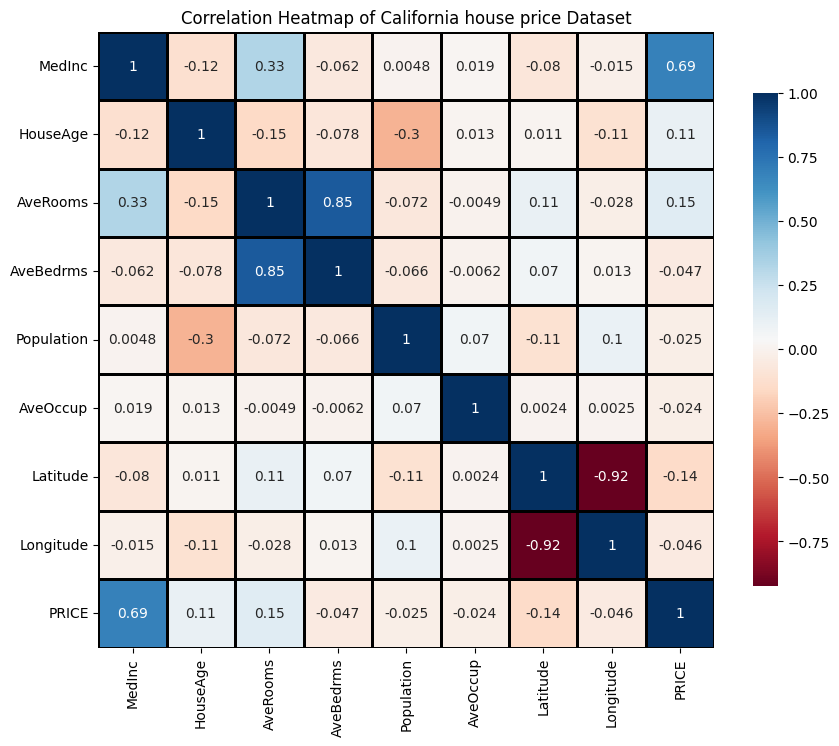

In [6]:
# seaborn heatmap visualization

correlation_matrix = df.corr() 
plt.figure(figsize=(10, 8)) 

sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', square=True,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of California house price Dataset', fontsize=12)
plt.show()

위 figure를 볼 때 아래와 같은 사실을 파악 가능하다.

- **PRICE와 MedInc, Longitude와 Latitude는 매우 높은 상관관계를 이룬다.** 약 0.69로써, 만일 두 attribute를 이용하여 linear regression한다면 높은 score를 기대해볼 수 있다.
- 또한, **AveBedrms와 AveRooms 또한 매우 높은 상관관계를 이룬다.** 0.85로, 평균 침실의 수가 많을 수록 방의 수도 높을 것이라는 추측이 가능하다. 만일 현 report가 classification question이였다면 이 feature를 반드시 사용했어야 할 것이다.
- 나머지 feature들은 서로의 상관관계가 매우 낮다. 연관성이 거의 없다고 봐도 무방할 정도이다.

따라서, 아래와 같은 plan을 세워보았다.
- **target은 PRICE로 둘 것이니, PRICE와 상관관계가 높은 MedInc feature에 거의 모든 것이 결정되어 있다고 무방하다.**
- feature importances의 불균형이 발생할 것이기 때문에, 각 **feature들 끼리의 내적을 통하여 feature를 추가한 set을 하나 마련**해놓아야 겠다. (PolynormialFeature 메소드 사용)

#### (4) seaborn pairplot으로 상관관계 시각화

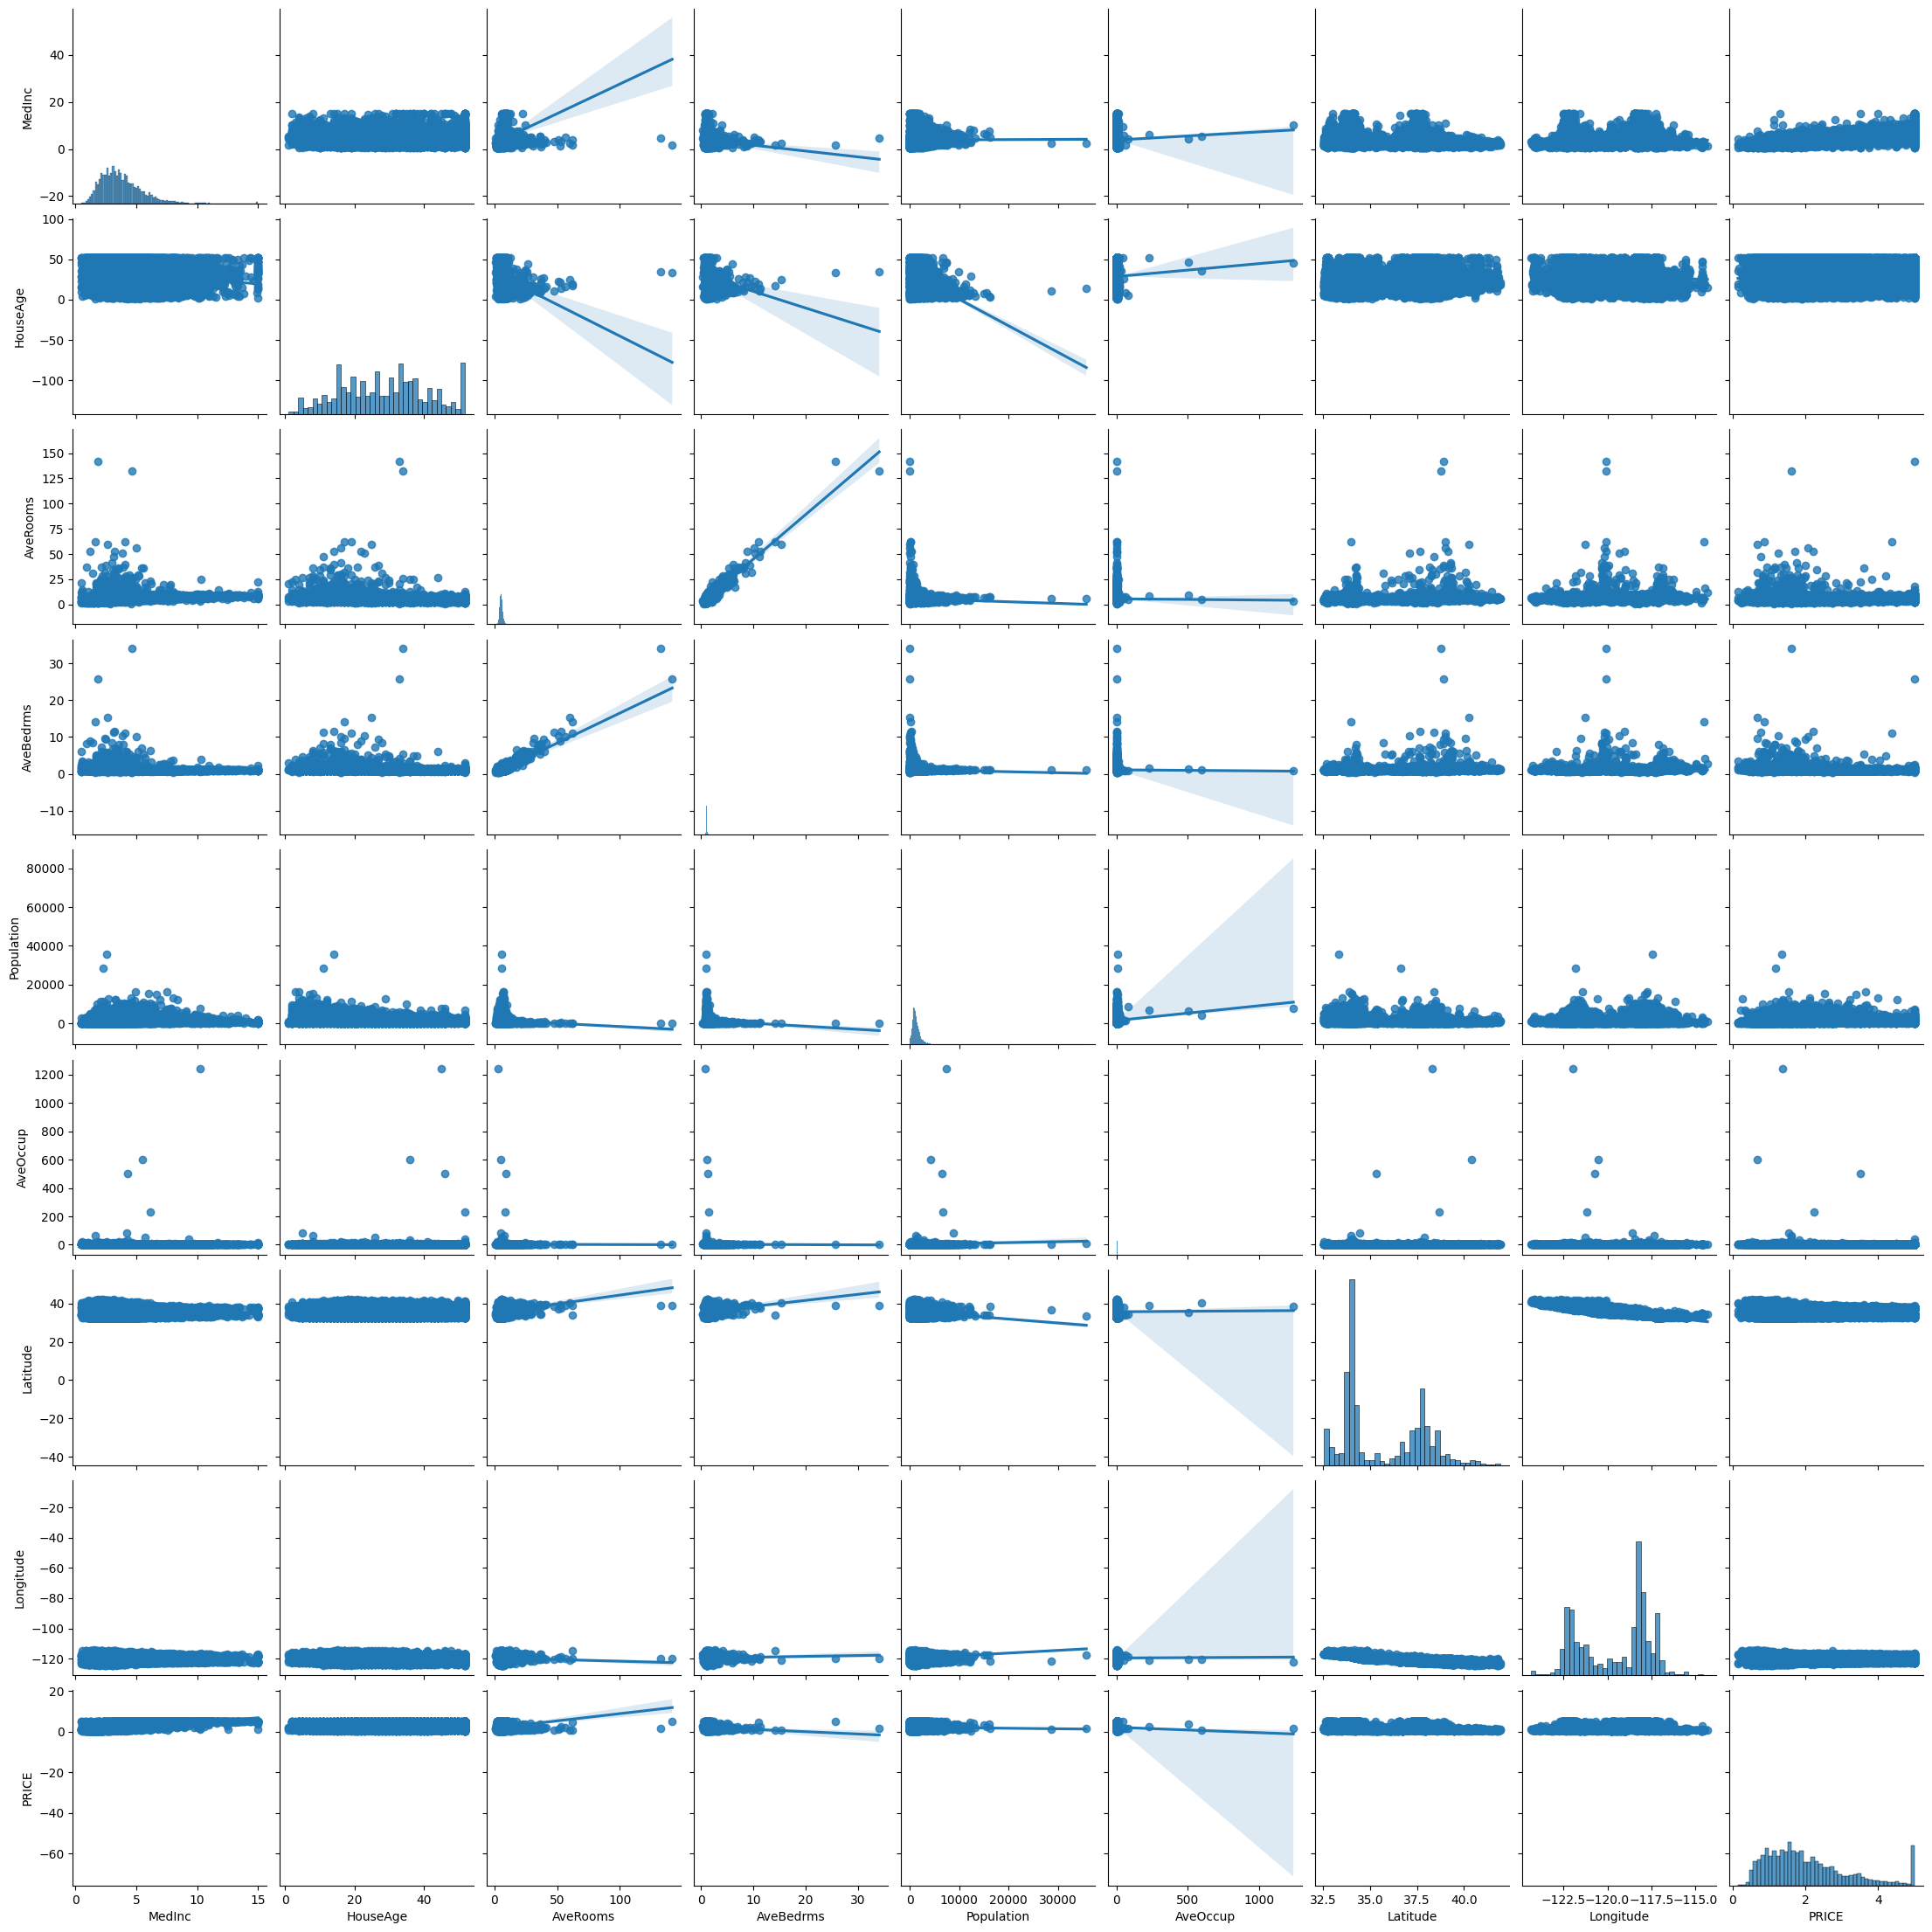

In [7]:
# pairplot 시각화

sns.pairplot(df, kind="reg")

#### (5) outlier 확인 위해 boxplot 시각화

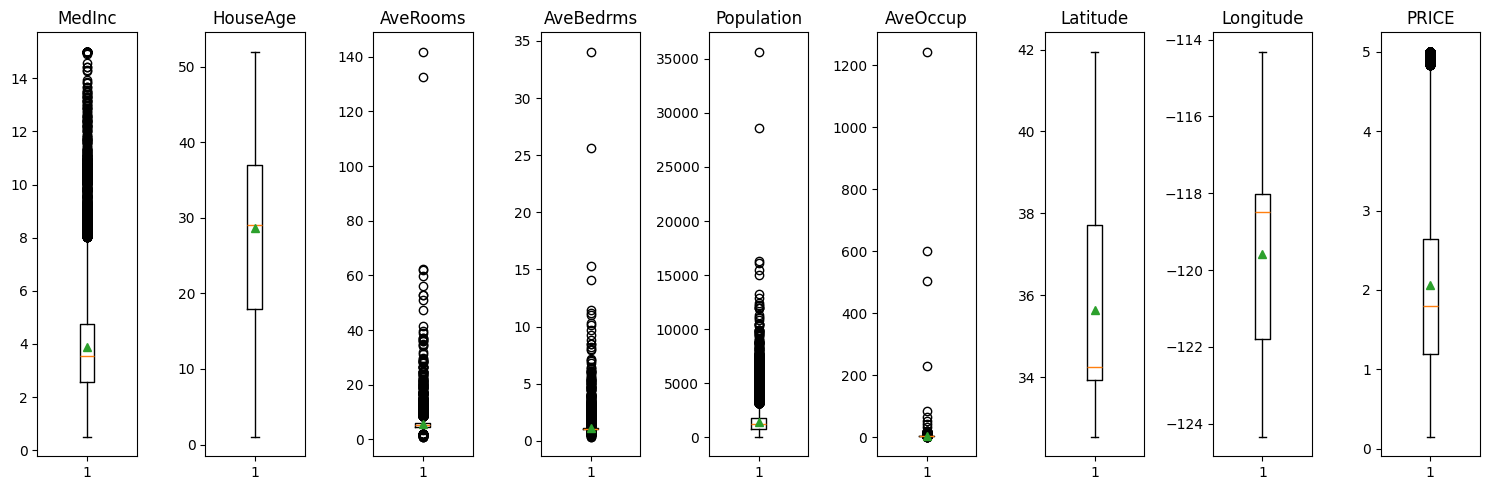

In [8]:
# box plot 그려 데이터 분포 확인

attr_list = df.columns

# subplot 생성
fig, axes = plt.subplots(nrows=1, ncols=len(attr_list), figsize=(15, 5))

# 각 변수에 대한 boxplot 그리기
for i, var in enumerate(attr_list) :
    ax = axes[i]
    ax.boxplot(df[var], showmeans=True)
    ax.set_title(var)

plt.tight_layout()
plt.show()

#### (6) 결측치 확인 및 filling by evarage value

In [9]:
# 결측치 확인 및 평균값으로 대체

print ("결측치 확인 : ")
print (df.isnull().sum())

df.fillna(df.mean())

print ("결측치 평균값 filling 후 : ")
print (df.isnull().sum())

결측치 확인 : 
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
PRICE         0
dtype: int64
결측치 평균값 filling 후 : 
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
PRICE         0
dtype: int64


#### (7) input, target set -> train, test, val set으로 split

In [10]:
# input, target set으로 split

columns = list(df.columns)
print (columns)

california_input = df[['MedInc', 'HouseAge', 'AveRooms', 
                      'AveBedrms', 'Population', 'AveOccup', 
                      'Latitude', 'Longitude']].to_numpy()
california_target = df['PRICE'].to_numpy()

print (california_input.shape, california_target.shape)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'PRICE']
(20640, 8) (20640,)


In [11]:
# train, test, val set으로 split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(california_input,
                                                   california_target, 
                                                   test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train, 
                                                  test_size=0.2)

print (X_train.shape, X_test.shape, X_val.shape)

(13209, 8) (4128, 8) (3303, 8)


#### (8) Polynormial Feature set 생성

In [12]:
# PolynormialFeature set 생성

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures()

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_val_poly = poly.transform(X_val)

print (poly.degree, poly.get_feature_names_out())
print (X_train_poly.shape, X_test_poly.shape, X_val_poly.shape)

2 ['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x0^2' 'x0 x1' 'x0 x2'
 'x0 x3' 'x0 x4' 'x0 x5' 'x0 x6' 'x0 x7' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4'
 'x1 x5' 'x1 x6' 'x1 x7' 'x2^2' 'x2 x3' 'x2 x4' 'x2 x5' 'x2 x6' 'x2 x7'
 'x3^2' 'x3 x4' 'x3 x5' 'x3 x6' 'x3 x7' 'x4^2' 'x4 x5' 'x4 x6' 'x4 x7'
 'x5^2' 'x5 x6' 'x5 x7' 'x6^2' 'x6 x7' 'x7^2']
(13209, 45) (4128, 45) (3303, 45)


#### (9) scaling (Z-score normalization)

In [13]:
# scaling

from sklearn.preprocessing import StandardScaler

z_normal = StandardScaler()

X_train_scaled = z_normal.fit_transform(X_train)
X_test_scaled = z_normal.transform(X_test)
X_val_scaled = z_normal.transform(X_val)

z_normal = StandardScaler()
X_train_poly_scaled = z_normal.fit_transform(X_train_poly)
X_test_poly_scaled = z_normal.transform(X_test_poly)
X_val_poly_scaled = z_normal.transform(X_val_poly)

--------

-------

### 2. 각종 모델을 적용하여 regression
- model : KNN, multiple regression, SVM, lasso, ridge, decision tree, random forest, gradient boosting, XGBoost, GPR
- **그동안 작성한 regression 절차와 다르게 진행할 것.**
- 아래와 같이 진행한다.
    - **목표**
        - 각 모델별로 random search하여 최적의 hyperparamter를 찾고, 그 hyperparameter로 fit 
            - fit은 X_train_scaled와 X_train_poly_scaled 이렇게 두번 진행 (normal set과 polynormial set의 성능을 비교할 예정)
    - **순서**
        - (1) 모델 리스트와 hyperparamater의 distributions 및 parameter scale을 정의
        - (2) 사용자 지정 함수를 생성하여, 모델을 순차적으로 학습할 수 있도록 함수형 프로그래밍을 진행
        - (3) normal set fit, visualization
            - visualization은 loss와 r^2 
                - loss : train set MSE, val set MSE, test set MSE
                - r^2 : train set r^2, val set r^2, test set r^2
        - (4) polynormial set fit, visualization
            - **<mark>원래는 이를 진행하려고 했으나, scikit-learn의 광대한 학습시간으로 인하여 본 과정을 생략한다.</mark>**

#### (1) 모델 리스트와 hyperparamater의 distributions 및 parameter scale을 정의
각 모델에 사용할 random search의 parameter scale는 아래와 같다.

- **KNN**
  - **n_neighbors** : 1 ~ 30
  - **weights** : 'uniform', 'distance'

- **lasso**
  - **alpha** : 0.001 ~ 1.0 (continuous)

- **ridge**
  - **alpha** : 0.001 ~ 10.0 (continuous)

- **SVM**
  - **C** : 0.1 ~ 10.0 (continuous)
  - **kernel** : 'linear', 'rbf'
  - **gamma** : 'scale', 'auto'

- **decision tree**
  - **max_depth** : 1 ~ 20
  - **min_samples_split** : 2 ~ 20

- **gradient boosting**
  - **n_estimators** : 50 ~ 200
  - **learning_rate** : 0.01 ~ 0.2 (continuous)
  - **max_depth** : 3 ~ 10
  
- **random forest** 
    - **max_feature** : 'auto', 'sqrt', 'None'
    - **max_depth'** np.arange(5, 50, 5)
    - **min_samples_leaf**: np.arange(1, 20, 2)

- **XGBoost**
  - **n_estimators** : 50 ~ 200
  - **learning_rate** : 0.01 ~ 0.2 (continuous)
  - **max_depth** : 3 ~ 10

- **GPR (Gaussian Process Regression)**
  - **alpha** : 0.0001 ~ 0.1 (continuous)

In [14]:
# random search에 사용될 각 parameter의 scale을 dictionary로 정리
# model list 정의

# scipy import (for regular distributions)
from scipy.stats import uniform, randint

# model import
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models = { # model 리스트
    "KNN" : KNeighborsRegressor(),
    "lasso" : Lasso(),
    "ridge" : Ridge(),
    "SVM" : SVR(),
    "decision tree" : DecisionTreeRegressor(),
    "random forest" : RandomForestRegressor(),
    "gradient boosting" : GradientBoostingRegressor(),
    "XGBoost" : XGBRegressor(),
    "GPR" : GaussianProcessRegressor()
}

param_scale = { # parameter scale
    "KNN" : {
        'n_neighbors' : randint(1, 30),
        'weights' : ['uniform', 'distance']
    },
    
    "lasso" : {
        'alpha' : uniform(0.001, 1.0)
    },
    
    "ridge" : {
        'alpha' : uniform(0.001, 10.0)
    },
    
    "SVM" : {
        'C' : uniform(0.1, 10),
        'kernel' : ['linear', 'rbf'],
        'gamma' : ['scale', 'auto']
    },
    
    "decision tree" : {
        'max_features': ['sqrt', 'log2', None],  
        'max_depth': np.arange(5, 50, 5),
        'min_samples_leaf': np.arange(1, 20, 2)
    },
    
    "random forest" : {
        'max_depth' : randint(1, 20),
        'min_samples_split' : randint(2, 20)
    },
    
    "gradient boosting" : {
        'n_estimators' : randint(50, 200),
        'learning_rate' : uniform(0.01, 0.2),
        'max_depth' : randint(3, 10)
    },
    
    "XGBoost" : {
        'n_estimators' : randint(50, 200),
        'learning_rate' : uniform(0.01, 0.2),
        'max_depth' : randint(3, 10)
    },
    
    "GPR" : {
        'alpha' : uniform(0.0001, 0.1)
    }
}

#### (2) 사용자 지정 함수를 생성하여, 모델을 순차적으로 학습할 수 있도록 함수형 프로그래밍을 진행

- 사용자 지정 함수의 이름은 **model_fit_procedurally**
- model_fit_procedurally의 paramter는 model_name, X_train, y_train, X_val, y_val, X_test, y_test이다. 
    - model_name은 여기서 model의 이름을 의미한다. (models 딕셔너리에서 keys에 해당)
    - models를 model_name으로 접근할 예정, model의 api를 의미한다. (models 딕셔너리에서 values에 해당)
- 각 모델에 대해 **random search -> best_model 도출 및 parameter 출력 + fit -> fit 후에 MSE 계산 및 출력 -> results에 MSE, r^2 저장** 순으로 진행
- random search의 n_iter 수는 100으로 고정
- random search의 scoring에 **neg_mean_squared_error**를 사용한다.
    - reference : https://velog.io/@ann9902/%EC%95%99%EC%83%81%EB%B8%94
    - scikit-learn의 내부 원리에 의해, 높을 수록 좋은 효용 함수를 적용하기 때문에, MSE의 반대를 계산한다.

In [15]:
# 모델 학습 및 평가
def model_fit_procedurally (model_name, X_train, y_train, X_val, y_val, X_test, y_test) : # models 딕셔너리의 구성 : key(모델이름) -> value(모델api)
    
    # CAUTION!
    # 여기서 X_train, y_train ... <-- 이 set은 지역변수이므로, 기존 train set, val set, test set에 영향을 끼치지 않음
    
    print(f"************** Activated : {model_name} **************")
    
    random_search = RandomizedSearchCV(
        models[model_name], param_scale[model_name], 
        n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) # neg_mean_squard_error 적용 (내부 원리 때문)
    
    # random search 진행
    random_search.fit(X_train, y_train) # 입력받은 paramter
    best_model = random_search.best_estimator_
    
    # train MSE, r^2
    y_train_pred = best_model.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # val MSE, r^2
    y_val_pred = best_model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # test MSE, r^2
    y_test_pred = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    result = {
        'train_mse': train_mse,
        'train_r2': train_r2,
        'val_mse': val_mse,
        'val_r2': val_r2,
        'test_mse': test_mse,
        'test_r2': test_r2
    }
    
    best_params = random_search.best_params_
    
    print(f"{model_name} | best params : {best_params}")
    
    print(f"{model_name} | train MSE : {train_mse}, R^2: {train_r2}")
    print(f"{model_name} | validation MSE : {val_mse}, R^2: {val_r2}")
    print(f"{model_name} | test MSE : {test_mse}, R^2: {test_r2}")
    
    return result, best_params

#### (3) normal set fit, visualization

In [16]:
# normal set fit

import time

results_normal = {}

for model_name in models.keys() :
    start_time = time.time() # 각 모델별로 소요 시간 측정
    
    rst_normal, _ = model_fit_procedurally(model_name, 
                                          X_train_scaled, y_train,
                                          X_val_scaled, y_val,
                                          X_test_scaled, y_test)
    
    end_time = time.time()
    
    print ("turnaround time: ", end_time - start_time)
    print()
    
    results_normal[model_name] = rst_normal
    
    
print (results_normal)

************** Activated : KNN **************
KNN | best params : {'n_neighbors': 14, 'weights': 'distance'}
KNN | train MSE : 0.0, R^2: 1.0
KNN | validation MSE : 0.4126707802789011, R^2: 0.6812468836980685
KNN | test MSE : 0.4185219736612559, R^2: 0.69555183830871
turnaround time:  19.04443120956421

************** Activated : lasso **************
lasso | best params : {'alpha': 0.018165667794112106}
lasso | train MSE : 0.5353455386229131, R^2: 0.59657171544815
lasso | validation MSE : 0.5338684299414826, R^2: 0.5876319965662287
lasso | test MSE : 0.5476360493817246, R^2: 0.6016295463494776
turnaround time:  0.6881170272827148

************** Activated : ridge **************
ridge | best params : {'alpha': 9.690685105514257}
ridge | train MSE : 0.5190758213090826, R^2: 0.6088323278424292
ridge | validation MSE : 0.5172598057977227, R^2: 0.6004607476101795
ridge | test MSE : 0.5490225513347857, R^2: 0.6006209542148804
turnaround time:  0.6493997573852539

************** Activated : SV

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SVM | best params : {'C': 9.674789605891293, 'gamma': 'auto', 'kernel': 'rbf'}
SVM | train MSE : 0.29280098078219047, R^2: 0.7793496183868216
SVM | validation MSE : 0.3269645606334982, R^2: 0.7474476565755825
SVM | test MSE : 0.32765638375575795, R^2: 0.7616507854337996
turnaround time:  1465.5287680625916

************** Activated : decision tree **************
decision tree | best params : {'min_samples_leaf': 17, 'max_features': None, 'max_depth': 30}
decision tree | train MSE : 0.23461266003289816, R^2: 0.823199455038538
decision tree | validation MSE : 0.34397606844053324, R^2: 0.734307712131679
decision tree | test MSE : 0.36881597991743414, R^2: 0.7317097926640377
turnaround time:  3.8139069080352783

************** Activated : random forest **************


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


random forest | best params : {'max_depth': 18, 'min_samples_split': 3}
random forest | train MSE : 0.045170920097199085, R^2: 0.9659598791963077
random forest | validation MSE : 0.24561519567780907, R^2: 0.8102831293737394
random forest | test MSE : 0.26449080460758734, R^2: 0.8075997335513748
turnaround time:  376.1744511127472

************** Activated : gradient boosting **************
gradient boosting | best params : {'learning_rate': 0.10541630707021163, 'max_depth': 7, 'n_estimators': 160}
gradient boosting | train MSE : 0.05709165886578019, R^2: 0.9569765911233927
gradient boosting | validation MSE : 0.2062003818484121, R^2: 0.8407277242832449
gradient boosting | test MSE : 0.2183530617630217, R^2: 0.8411620119443906
turnaround time:  453.0228781700134

************** Activated : XGBoost **************


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGBoost | best params : {'learning_rate': 0.16125203780845035, 'max_depth': 6, 'n_estimators': 199}
XGBoost | train MSE : 0.05895415527614343, R^2: 0.9555730420553467
XGBoost | validation MSE : 0.20040294525741698, R^2: 0.8452057514861732
XGBoost | test MSE : 0.21515364906189421, R^2: 0.8434893815370286
turnaround time:  63.30600190162659

************** Activated : GPR **************


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GPR | best params : {'alpha': 0.08528479197195761}
GPR | train MSE : 0.2033797235430052, R^2: 0.846736122630924
GPR | validation MSE : 0.3233840164963625, R^2: 0.7502133227102123
GPR | test MSE : 0.3304751392143484, R^2: 0.7596003198151897
turnaround time:  11013.818216085434

{'KNN': {'train_mse': 0.0, 'train_r2': 1.0, 'val_mse': 0.4126707802789011, 'val_r2': 0.6812468836980685, 'test_mse': 0.4185219736612559, 'test_r2': 0.69555183830871}, 'lasso': {'train_mse': 0.5353455386229131, 'train_r2': 0.59657171544815, 'val_mse': 0.5338684299414826, 'val_r2': 0.5876319965662287, 'test_mse': 0.5476360493817246, 'test_r2': 0.6016295463494776}, 'ridge': {'train_mse': 0.5190758213090826, 'train_r2': 0.6088323278424292, 'val_mse': 0.5172598057977227, 'val_r2': 0.6004607476101795, 'test_mse': 0.5490225513347857, 'test_r2': 0.6006209542148804}, 'SVM': {'train_mse': 0.29280098078219047, 'train_r2': 0.7793496183868216, 'val_mse': 0.3269645606334982, 'val_r2': 0.7474476565755825, 'test_mse': 0.32765638

참고로, 위에 있는 **turnaround time**은 각 모델별로 random search한 초 수를  나타낸다. 정말 오래 걸렸음을 눈으로 파악 가능하다. 

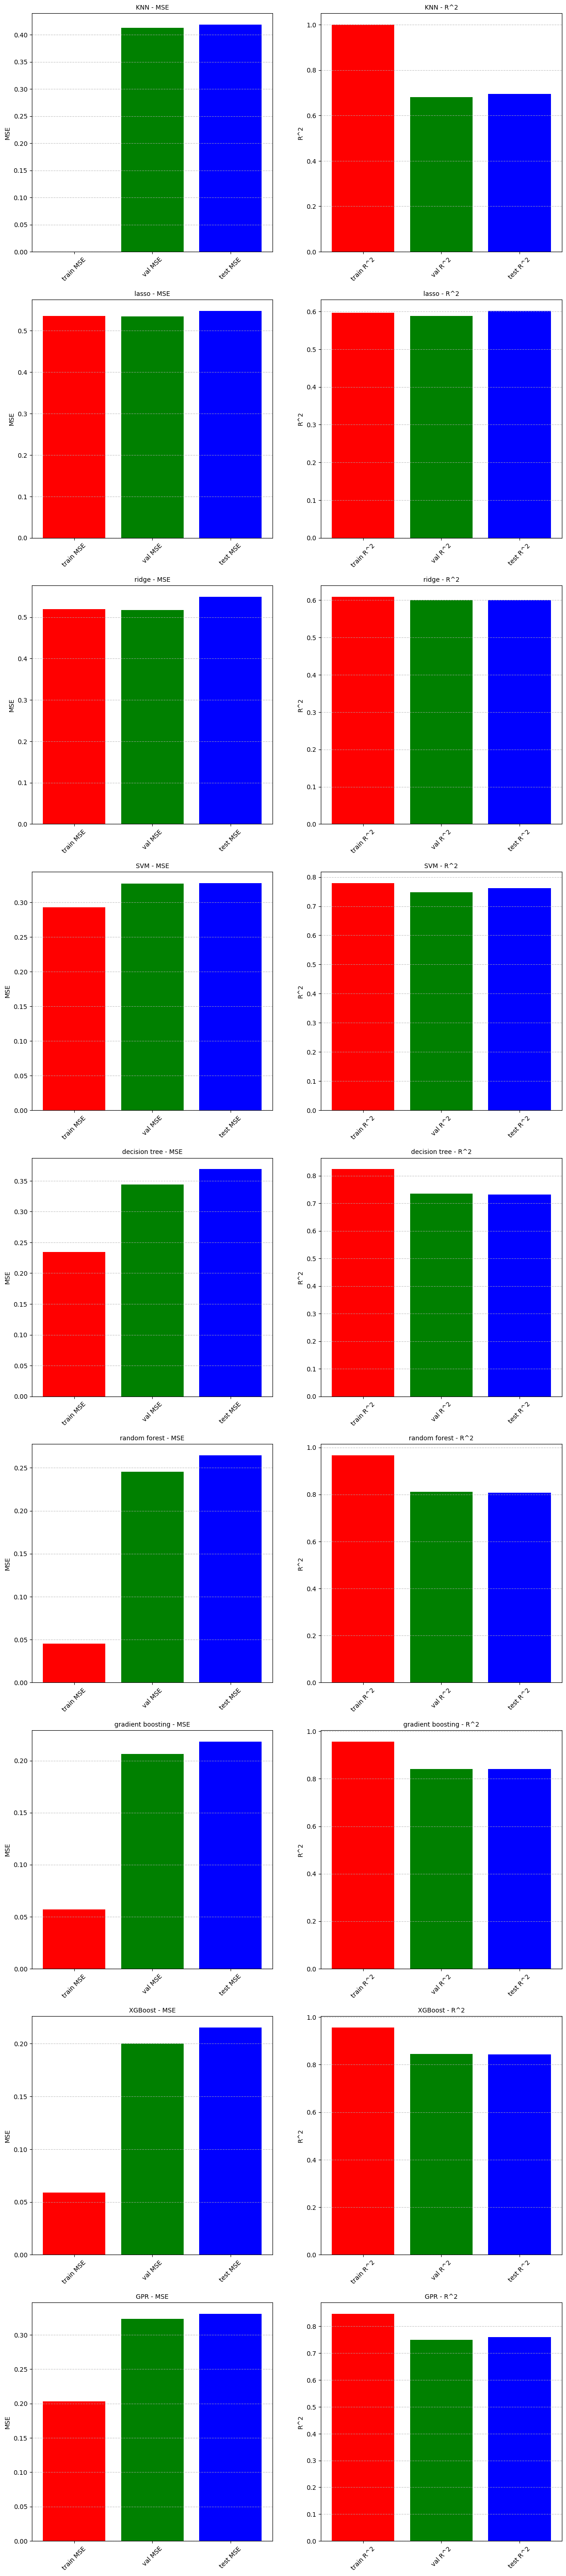

In [20]:
# visualization each MSE and R^2

model_name = list(models.keys())

fig, axes = plt.subplots(len(model_name), 2, figsize=(15, len(model_name) * 8))

for i, model in enumerate(model_name) :
    axes[i][0].bar(['train MSE', 'val MSE', 'test MSE'], 
                   [results_normal[model]['train_mse'], 
                    results_normal[model]['val_mse'], 
                    results_normal[model]['test_mse']],
                  color=['r', 'g', 'b'])
    
    axes[i][0].set_title(f'{model} - MSE', fontsize=10)
    axes[i][0].set_ylabel('MSE')
    axes[i][0].tick_params(axis='x', rotation=45)
    axes[i][0].grid(True, axis='y', linestyle='--', alpha=0.7)

    axes[i][1].bar(['train R^2', 'val R^2', 'test R^2'], 
                   [results_normal[model]['train_r2'], 
                    results_normal[model]['val_r2'], 
                    results_normal[model]['test_r2']],
                   color=['r', 'g', 'b'])
    
    axes[i][1].set_title(f'{model} - R^2', fontsize=10)
    axes[i][1].set_ylabel('R^2')
    axes[i][1].tick_params(axis='x', rotation=45)
    axes[i][1].grid(True, axis='y', linestyle='--', alpha=0.7)

plt.show()
